# __Group Project 4 - Team Luther Burbank__
<br>


### <span style = "color:dark">__Team Members: Yingyin Li, William Lee, Kanay Mathur, Kevin Kim, Qianhao (Harry) Zhong__
<br>



## **1. Project Topic & Goal:**

We intend to analyze the food demand system in Panama, evaluate the nutritional composition of various food items, and assess the nutritional sufficiency of households in Panama. Our objectives include establishing criteria for essential nutrients, identifying prevalent nutritional deficiencies, and examining challenges faced by Panamanian households in meeting recommended dietary intakes.
    
> * Preliminary findings suggest that a significant portion of Panamanian households exhibit deficiencies in essential nutrients such as vitamin A, vitamin C, and fiber, with a notable percentage failing to meet recommended daily intake levels. 
> * Furthermore, while carbohydrate consumption generally aligns with recommendations for most households, there exists a subset that surpasses the recommended intake. This excess intake may predispose individuals to issues such as caloric surplus, elevated blood glucose levels, and nutrient imbalances, warranting further investigation and intervention.*

<br>


## **2. Policy Exploration:**

Our policies are designed to elevate the nutritional quality of Panamanian households by targeting the attainment of vitamin and fiber sufficiency in two-thirds of the population. To realize these objectives, our strategies encompass:

>* Implementing food stamp programs or subsidies aimed at reducing the cost of high-vitamin and high-fiber foods in the market, particularly fruits and vegetables.
>* Providing subsidies to local restaurants contingent upon the adaptation of their menus to include a minimum of 70% items rich in vitamins and fiber.
>* Introducing tax incentives for farmers engaged in the production of fiber-rich foods, thereby encouraging the cultivation and availability of such dietary essentials.

<br>
    
## **3. Data(set) Description:**

> ####  __Main DataSet - [Panama Dataset](https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=2085637103):__ This spreadsheet encompasses all the data we aim to manipulate. It contained subsheets titled <span style = "color:red"> <u>Household Characteristics, FCT (Food Composition Table), Food Expenditures, RDI (Recommended Dietary Intake), and Food Prices</span>.
> * #### __Subsheet 1 - [Household Characteristics](https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=1095902684):__ This subsheet presents household data collected from multiple provinces in Panama, including Herrera, Bocas Del Toro, Chiriquí, Colón, and Panamá, spanning the years 1997 to 2008. It offers a detailed breakdown of household composition by gender and age group across these provinces, providing insight into the demographic diversity within the surveyed regions over the specified timeframe.
> * #### __Subsheet 2 - [FCT](https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=881999882):__ This sheet provides a comprehensive overview of the nutritional content of different foods per 100 grams of edible portion. Each row corresponds to a specific food item, while the columns contain data regarding its water content, energy value, macronutrient composition, and other nutritional components.
> * #### __Subsheet 3 - [Food Expenditures](https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=2085637103):__ This dataset is structured as a multi-indexed dataset, featuring information on food expenditure across diverse households. The indexing incorporates three levels: year, region, and household identifier. This hierarchical organization facilitates systematic analysis, enabling examination of fluctuations in food expenditure over time, disparities across geographical regions, and variations among individual households.
> * #### __Subsheet 4 - [Food Prices](https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=1029038038):__ This spreadsheet seems to comprise a collection of food items alongside their prices and measurements across different regions and time periods in Panama. Each row likely represents a unique food item and its corresponding measurement, while each column denotes various regions or time periods. The values within each cell likely indicate the corresponding price and unit of measurement for the specified region or period, providing a comprehensive overview of food prices and availability over time and across different geographical areas within Panama.
> * #### __Subsheet 5 - [RDI](https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=342562131):__ This sheet outlines recommended daily intake levels of various nutrients for different age and gender groups. It spans from infancy to older adulthood, detailing values for nutrients such as Energy, Protein, Fiber, Folate, Calcium, and more. Each demographic group, categorized by age and gender, has specific recommended intake levels for optimal nutrition.

<br>

## **4. Project Deliverables:**

### *Packages Import*:

In [1]:
# The lengthy output has been hidden
# Try to re-run this code if you encounter "ERROR: pip's dependency resolver does not currently take into account all the packages that are installed."
!pip install -r requirements.txt -q
!pip install CFEDemands --upgrade --pre -q
!pip install eep153_tools --upgrade -q

In [2]:
from cfe.estimation import drop_columns_wo_covariance
from eep153_tools.sheets import read_sheets
import matplotlib.pyplot as plt
from cfe import Regression
import numpy as np
import pandas as pd
import cfe

<br>

### *DATA Import, DATA Cleaning*:

In [3]:
InputFiles = {"Expenditures": ("1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE", "Food Expenditures"),
              'Prices':('1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE','Food Prices'),
              'HH Characteristics':('1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE','Household Characteristics'),
              'FCT':('1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE','FCT'),
              'RDI':('1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE','RDI')}

In [4]:
def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

In [5]:
################# Get expenditures #################
Expenditures = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in Expenditures.columns:  # If Expenditures doesn't include column "m", create one manually.
    Expenditures['m'] = 1
    
Expenditures = Expenditures.set_index(['i','t','m'])
Expenditures.columns.name = 'j'

Expenditures = Expenditures.apply(lambda x: pd.to_numeric(x,errors='coerce'))
Expenditures = Expenditures.replace(0,np.nan)  # Convert all zeros to NaN


################# Get HH characteristics #################
HH_characteristics = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in HH_characteristics.columns:
    HH_characteristics['m'] = 1

HH_characteristics = HH_characteristics.set_index(['i','t','m'])
HH_characteristics.columns.name = 'k'  # Assign a overarching column name to coloumn indexes

HH_characteristics = HH_characteristics.apply(lambda x: pd.to_numeric(x,errors='coerce'))



################# Get prices #################
price_url = 'https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=2085637103'

prices = read_sheets(price_url, sheet='Food Prices', nheaders=2)
prices.columns.names = ['t', 'm']  # Assign two column names to two headers
# since there are multiple prices for food in various sizes, we choose to use average price 
prices.groupby(level='j').mean()
prices=prices.transpose()
if 'm' not in prices.columns:  # Supply "market" indicator if missing
    prices['m'] = 1  
prices = prices.apply(lambda x: pd.to_numeric(x,errors='coerce'))
prices = prices.replace(0,np.nan)



################# fct #################
fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

fct = fct.set_index('j')
fct.columns.name = 'n'
fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))



################# RDI, if available (consider using US) #################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])

rdi = rdi.set_index('n')
rdi.columns.name = 'k'
new_column_names = [
"Females 00-03", "Males 00-03", "Females 04-08", "Males 04-08", "Females 09-13", "Males 09-13", 
    "Females 14-18", "Males 14-18",  "Females 19-30", "Males 19-30", "Females 31-50", "Males 31-50",  "Females 51-99", "Males 51-99"]
column_name_mapping = {old: new for old, new in zip(rdi.columns, new_column_names)}
rdi.rename(columns=column_name_mapping, inplace=True)

### From above, we get "Expenditures", "HH_characteristics", "prices", "fct", "rdi"

<br>

### *Cleaned DataFrame Display*:

In [6]:
Expenditures.head()

,,j,Aceite Vegetal,Aguacates,Ahí Verde,Ajo,Alimento Infantil,Apio,Arroz,Arvejas,Azúcar,Café Y Té,...,"Sodas, Refrescos Y Jugos",Sopa Enlatada,Tercer otro,Tomate,Viscera De Res,Visceras De Pollo O Gallina,Yuca,Zanahoria,Zapallo / Chayote,Ñame
i,t,m,,,,,,,,,,,,,,,,,,,,,
19971000,1997,Chíriqui,6.0,NaN,0.5,NaN,2.7,0.3,7.25,NaN,1.6,NaN,...,8.0,0.7,NaN,NaN,NaN,NaN,NaN,0.8,NaN,0.4
19971001,1997,Chíriqui,NaN,NaN,NaN,NaN,NaN,NaN,4.80,NaN,NaN,1.4,...,1.5,NaN,NaN,0.3,NaN,NaN,NaN,NaN,NaN,NaN
19971002,1997,Chíriqui,3.5,NaN,NaN,NaN,NaN,NaN,6.00,NaN,2.0,3.6,...,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
19971003,1997,Chíriqui,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19971005,1997,Chíriqui,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,1.5,...,NaN,0.7,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [7]:
HH_characteristics.head()

,,k,women,boys,men,girls,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
1997125,1997,Herrera,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1.098612
1997160,1997,Herrera,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1.098612
1997170,1997,Bocas Del Toro,1,3,1,4,1,2,1,0,0,1,1,1,0,0,0,1,1,0,2.197225
1997177,1997,Bocas Del Toro,4,9,1,5,2,1,4,1,1,3,2,0,0,2,0,2,1,0,2.944439
1997178,1997,Bocas Del Toro,2,1,2,2,0,0,0,1,1,0,0,1,2,0,0,1,0,1,1.945910


In [8]:
prices.head()

j                   Aceite Vegetal                                            \
u                       1/2 gallon  None bottle    can gallon gram large bay   
t    m                                                                         
1997 Bocas Del Toro          3.225   NaN   1.20  2.975   6.70  NaN     1.500   
     Chíriqui                3.250  0.10   1.35    NaN   5.95  NaN     1.350   
     Coclé                   2.990  0.10   1.30    NaN   5.90  NaN     1.375   
     Colón                   3.250  0.10   1.34    NaN   5.75  NaN       NaN   
     Darién                  3.200  0.25   1.40    NaN   4.85  NaN     1.525   

j                                                ... Zapallo / Chayote  \
u                   liter medium bar milliliter  ...              unit   
t    m                                           ...                     
1997 Bocas Del Toro   NaN      1.050        NaN  ...              0.10   
     Chíriqui         NaN      1.325        NaN  ...              0.10   
     Coclé            NaN      1.275        NaN  ...              0.15   
     Colón            NaN      0.850        NaN  ...              0.25   
     Darién           NaN      1.400        NaN  ...               NaN   

j                                    Ñame                                 \
u                       value bag or sack gram ounce package pound  unit   
t    m                                                                     
1997 Bocas Del Toro       NaN         3.6  NaN   NaN     NaN  0.40   NaN   
     Chíriqui        0.084416         NaN  NaN   NaN     NaN  0.40  0.15   
     Coclé           0.201299         NaN  NaN   NaN     NaN  0.50  0.50   
     Colón           0.045455         NaN  NaN   NaN     NaN  0.40  0.60   
     Darién               NaN         NaN  NaN   NaN     NaN  0.15   NaN   

j                              m  
u                       value     
t    m                            
1997 Bocas Del Toro       NaN  1  
     Chíriqui        0.038961  1  
     Coclé                NaN  1  
     Colón           0.064935  1  
     Darién               NaN  1  

[5 rows x 691 columns]

In [9]:
fct.head()

n,Agua,Energía,Proteina,Grasa Total,Carbo-hidratos,Fibra Diet. total,Ceniza,Calcio,Fosforo,Hierro,...,Colesterol,Potasio,Sodio,Zinc,Magnesio,Vit. B6,Vit. B12,Ac. Fólico,Folato Equiv. FD,Fracción Comestible
j,,,,,,,,,,,,,,,,,,,,,
Aceite Vegetal,0.00,884,0.00,100.00,0.00,0.0,0.00,0,0,0.00,...,0,0,0,0.00,0,0.00,0.0,0,0,1.00
Aguacates,73.23,160,2.00,14.66,8.53,6.7,1.58,12,52,0.55,...,0,485,7,0.64,29,0.26,0.0,0,81,0.74
Ahí Verde,93.89,20,0.86,0.17,3.64,1.7,0.43,10,20,0.34,...,0,175,3,0.13,10,0.22,0.0,0,11,0.82
Ajo,63.80,134,5.30,0.20,29.30,0.0,1.40,38,134,1.40,...,0,529,19,1.00,0,0.00,0.0,3,0,0.94
Alimento Infantil,3.00,510,12.50,27.00,54.30,0.0,3.20,530,420,9.00,...,0,600,180,6.00,55,0.30,1.5,80,136,1.00


In [10]:
rdi.head()

k,Females 00-03,Males 00-03,Females 04-08,Males 04-08,Females 09-13,Males 09-13,Females 14-18,Males 14-18,Females 19-30,Males 19-30,Females 31-50,Males 31-50,Females 51-99,Males 51-99
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0


<br>


## __[A] Estimate Demand System__

* ### *Main Demand System Regression Equation:*

<br>

$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
<br>

> $y_{i}^j$ : *__Logarithmic expenditures on food $j$ by household $i$ at a particular time.__*
> 
> $A^j(p)$ : *__Sub-function of price $p$ of food $j$. It captures the demand elasticity of food $j$ .__*
>
> $\gamma_j'd_i$ : *__Variable $d_i$ represents household characteristics. The coefficient $\gamma_j'$ signifies how food expenditure changes in response to variations in household composition.__*
>
> $\beta_j w_i$ : *__Variable $w_i$ represents household wealth. The coefficient $\beta_j$ indicates how changes in household wealth affect food expenditure.__*
>
> $\zeta^j_i$ : *__The error term represents all sources of variation in the dependent variable ($y_{i}^j$) that are not explained by the independent variables included in regression function.__*

* ### *To enhance the accuracy of our demand prediction model given limited data, we broke down the main equation into a sub-equation comprising two available variables. We then conducted regression analysis, correlating food expenditure with household composition (characteristics) and food prices:*

<br>

$$
      y^j_{i} = \gamma_j'd_i + A^j(p) + \zeta^j_i.
$$
<br>

* ### *Integrating household characteristics with food prices yields valuable insights into the factors shaping household spending on various food items. This amalgamation enables the analysis of correlations between household demographics, such as size, and external factors like food prices across specific regions and years.*

> __This merged dataset facilitates addressing inquiries such as:__
> - __*How do fluctuations in food prices influence household expenditures on different food items?*__
> - __*Do variations in household size or composition lead to differences in food purchasing patterns?*__
> - __*Which food items exhibit greater sensitivity to price fluctuations, and how does this sensitivity vary across regions and demographic groups?*__

<br>



In [11]:
# Combining prices_pound and HH_characteristics_1
price_url = 'https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=2085637103'
prices = read_sheets(price_url, sheet='Food Prices', nheaders=2)
prices_pound = prices.loc[(slice(None), "pound"), :].T  # Filter out all rows that don't have column value "pound" and make it a new dataframe


# Dataframe Formatting for prices_value
prices_pound.columns.names = ['w', 'm']
prices_pound = prices_pound.droplevel('m', axis=1)
prices_pound = prices_pound.T
prices_pound.columns.names = ['t', 'm']
prices_pound = prices_pound.T
prices_pound.index = prices_pound.index.set_levels(prices_pound.index.levels[0].astype(int), level=0)  # Convert year of string type to numeric one.
prices_pound


# Dataframe Formatting for HH_characteristics
HH_characteristics_1 = HH_characteristics.T
HH_characteristics_1 = HH_characteristics_1.droplevel('i', axis=1)
HH_characteristics_1 = HH_characteristics_1.T
HH_characteristics_1


# Combine two Dataframe by matching multi-index
merged_df = pd.merge(HH_characteristics_1, prices_pound, left_index = True, right_index = True, how='left')
merged_df.fillna(0, inplace=True)


# Put the previously-removed household id back to the Dataframe
column_i = HH_characteristics.index.get_level_values('i')
column_i_df = pd.DataFrame(column_i, columns=['i'])
merged_df.reset_index(inplace=True)  # Add index manually


# Final Dataset Formatting
merged_df = pd.concat([column_i_df, merged_df], axis = 1)
merged_df = merged_df.set_index(['i','t','m'])
merged_df.columns.name = 'k'
merged_df.head()

,,k,women,boys,men,girls,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,...,Segundo otro,"Sodas, Refrescos Y Jugos",Tercer otro,Tomate,Viscera De Res,Visceras De Pollo O Gallina,Yuca,Zanahoria,Zapallo / Chayote,Ñame
i,t,m,,,,,,,,,,,,,,,,,,,,,
1997125,1997,Herrera,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.5,1.25,1.1,0.15,0.5,0.2,0.4
1997160,1997,Herrera,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,1.25,1.1,0.15,0.5,0.2,0.4
1997170,1997,Bocas Del Toro,1.0,3.0,1.0,4.0,1.0,2.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.7,1.20,0.5,0.20,0.6,0.3,0.4
1997177,1997,Bocas Del Toro,4.0,9.0,1.0,5.0,2.0,1.0,4.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.7,1.20,0.5,0.20,0.6,0.3,0.4
1997178,1997,Bocas Del Toro,2.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.7,1.20,0.5,0.20,0.6,0.3,0.4


<br>

* ### *Regression Setup, Result Saving and Result Overview*

In [12]:
# To enhance the model's accuracy, we may encounter foods with very low consumption rates, making it challenging to reliably estimate their demand. 
# We can adjust the min_obs parameter; increasing its value will result in dropping more foods from the analysis.
# Expenditures = drop_columns_wo_covariance(Expenditures,min_obs=30)

# Take the logarithm to Expenditures. 
Expenditures_log = np.log(Expenditures)
use = Expenditures_log.index.intersection(merged_df.index)
Expenditures_log = Expenditures_log.loc[use,:]
merged_df_matched = merged_df.loc[use,:]

Expenditures_log = Expenditures_log.stack()
merged_df_matched = merged_df_matched.stack()

# Check that indices are in right places.
assert Expenditures_log.index.names == ['i','t','m','j']
assert merged_df_matched.index.names == ['i','t','m','k']

# Remove Ruplicated Indexes.
Expenditures_log = Expenditures_log.groupby(level = Expenditures_log.index.names).mean()

### Regession SetUp
result = Regression(y = Expenditures_log,d = merged_df_matched)

In [13]:
result = cfe.regression.read_pickle('pj4_estimate_result.pickle')

In [14]:
## This code may take longer than 2 minutes to process.
result.predicted_expenditures()

i         t     m                    j                        
20081     2008  Bocas Del Toro       Aceite Vegetal               5.288339
                                     Ajo                          0.692437
                                     Arroz                        7.311953
                                     Azúcar                       3.079029
                                     Café Y Té                    2.596964
                                                                    ...   
20087040  2008  Comarca Ngobe Bugle  Queso (Blanco Y Amarillo)    1.747443
                                     Raspados Y Duros             1.359181
                                     Sal                          0.618434
                                     Sardina Y Atún               3.677415
                                     Sodas, Refrescos Y Jugos     2.659700
Length: 416806, dtype: float64

<br>

### 📈📊 *__Regression Result Analytics [I] - Model Accuracy:__*

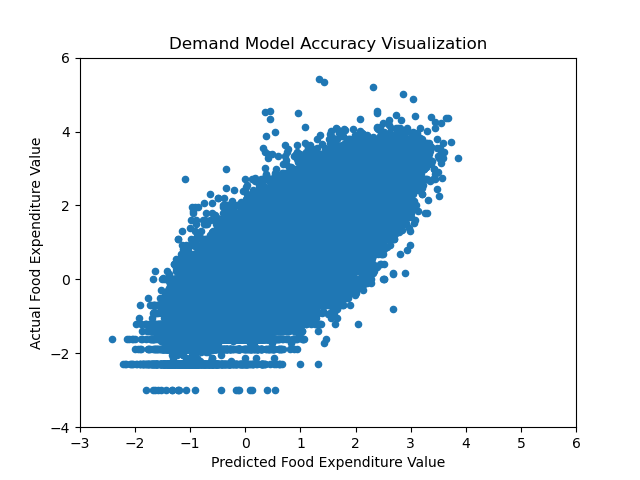

In [15]:
# Compare predicted logarithmic expenditures with actual expenditures:
%matplotlib widget
df = pd.DataFrame({'y':Expenditures_log, 'yhat':result.get_predicted_log_expenditures()})
ax = df.plot.scatter(x='yhat',y='y')

# Set the x-axis limits from -3 to 6 and the y-axis limits from -4 to 6
ax.set_xlim(-3, 6) 
ax.set_ylim(-4, 6)
plt.xlabel("Predicted Food Expenditure Value")
plt.ylabel("Actual Food Expenditure Value")
plt.title("Demand Model Accuracy Visualization")
plt.show()

# # Plot a trendline
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax], color = 'Salmon')

### *__<span style = "color:#1FF30E">Interpretation:__*
* <span style = "color:#1FF30E">__*The figure above presents a scatter plot juxtaposing the predicted food expenditures derived from our regression model against the actual logarithmic food expenditures.*__
* <span style = "color:#1FF30E">__*The depiction indicates a better level of predictive capability and accuracy within the model after combining the food prices with household characteristics.*__

In [16]:
# Our predicted result
regression_result = result.gamma

# Seperate the result into prices part and HH_characteristics part
HH_char_regression_result = regression_result.iloc[:, :19]  # First two columns
prices_regression_result = regression_result.iloc[:, 19:]  # Remaining columns

<br>

### 📈📊 *__Regression Result Analytics [II] - Coefficients of Household Characteristics:__*

In [17]:
HH_char_regression_result.head()

k,women,boys,men,girls,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
j,,,,,,,,,,,,,,,,,,,
Aceite Vegetal,-0.279741,-0.024983,-0.024060,-0.313845,-0.071561,0.201712,-0.035537,0.245528,-0.030347,0.254907,-0.011576,0.271751,0.010277,0.300921,0.035420,0.362683,0.054342,0.305659,0.343150
Ajo,0.134699,-0.030682,-0.006343,0.100107,-0.027076,-0.166284,-0.048766,-0.162973,-0.006369,-0.138375,-0.003593,-0.116260,-0.009174,-0.131387,0.015281,-0.083056,0.042628,-0.089703,0.190649
Arroz,-0.490754,-0.301524,-0.285209,-0.429082,0.251868,0.355174,0.255758,0.396293,0.323543,0.446158,0.386822,0.448854,0.348911,0.454263,0.376193,0.416498,0.374652,0.441405,0.583224
Azúcar,-0.172819,-0.409167,-0.447934,-0.141708,0.418831,0.165032,0.424705,0.162971,0.447470,0.186949,0.490488,0.176532,0.474475,0.171011,0.506233,0.190854,0.568229,0.224298,0.359284
Café Y Té,0.074437,0.040152,0.081201,0.055541,-0.036127,-0.041840,-0.019825,-0.039572,-0.003977,-0.046544,-0.011789,-0.007314,-0.019644,-0.032832,0.068431,0.051626,0.144316,0.101503,-0.030925


### *__<span style = "color:#1FF30E">Interpretation:__*
* <span style = "color:#1FF30E">__*Each cell in the table above corresponds to the coefficient of household characteristics in our regression model, representing the sought-after outcome of our regression analysis.*__
* <span style = "color:#1FF30E">__*For example, in the first cell, a value of -0.279741 signifies the average reduction in <u>"Aceite Vegetal" (Vegetable oil) </u>consumption by 0.279741 units for each additional woman in a Panamanian household.*__

Please choose from the following:
"women", "boys", "men", "girls", "Males 00-03", "Females 00-03", "Males 04-08", "Females 04-08", "Males 09-13", "Females 09-13", "Males 14-18", "Females 14-18",
 "Males 19-30", "Females 19-30", "Males 31-50", "Females 31-50", "Males 51-99", "Females 51-99"




Please input the first population group you would like to visualize (No quotation mark required):  women


Please input a population group you would like to visualize and compare with the first chosen one (No quotation mark required):  men


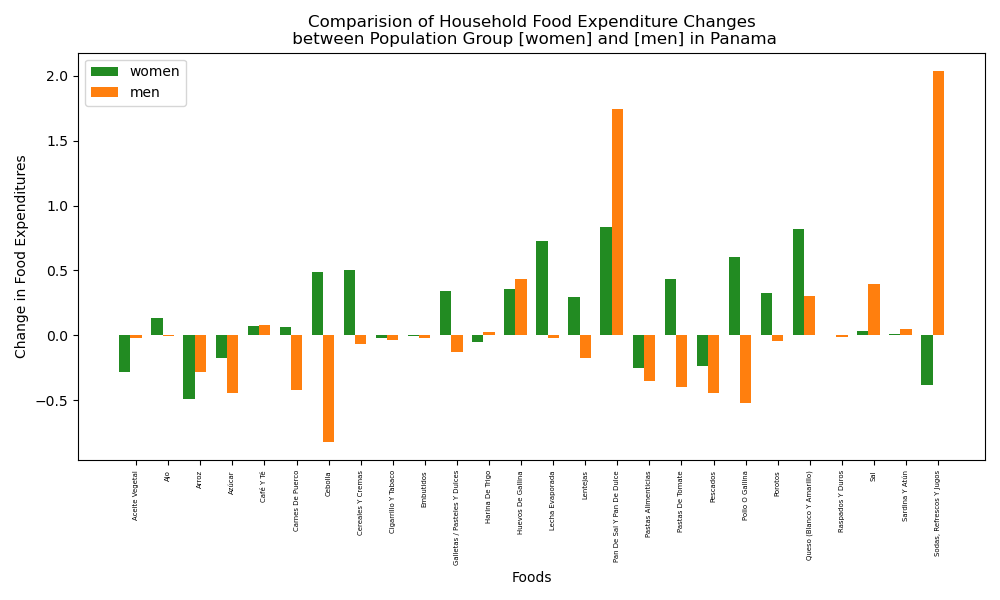

In [18]:
def plot_two_gamma_table(gamma_table, population_groups):
    """
    Ths function is designed to help combine two bar charts displaying food expenditure changes with variations of household composition, and do the comparision.
    
    Parameters:
    - gamma_table (DataFrame): The gamma table above.
    - population_group (list): It should be a list of two population group (string) from the header of gamma table

    Returns:
    - A bar chart described above.
    
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.7 
    num_groups = len(population_groups)
    bar_width = width / num_groups  # Adjusting the bar width for multiple groups
    colors = ['#228b22', '#ff7f0e']
    for i, population_group in enumerate(population_groups):
        x = range(len(gamma_table.index))
        ax.bar([pos + i * bar_width for pos in x], gamma_table[population_group], bar_width, label=population_group, color=colors[i])

    ax.set_title(f'Comparision of Household Food Expenditure Changes\n between Population Group [{population_groups[0]}] and [{population_groups[1]}] in Panama')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Food Expenditures')
    ax.set_xticks([pos + width / 2 for pos in x])
    ax.set_xticklabels(gamma_table.index, rotation=90, fontsize=5)
    ax.legend()
    plt.tight_layout()
    plt.show()

print('Please choose from the following:\n"women", "boys", "men", "girls", "Males 00-03", "Females 00-03", "Males 04-08", "Females 04-08", "Males 09-13", "Females 09-13", "Males 14-18", "Females 14-18",\n "Males 19-30", "Females 19-30", "Males 31-50", "Females 31-50", "Males 51-99", "Females 51-99"')
print("\n")  
population_input_list_1 = input('Please input the first population group you would like to visualize (No quotation mark required): ')
print("\n")  
population_input_list_2 = input('Please input a population group you would like to visualize and compare with the first chosen one (No quotation mark required): ')

population_groups = [population_input_list_1, population_input_list_2]  # List of population groups
plot_two_gamma_table(HH_char_regression_result, population_groups)

### *__<span style = "color:#1FF30E">Interpretation:__*
* <span style = "color:#1FF30E">__*Using women and men as examples, notable observations extend beyond the straightforward comparison of bar lengths in the figure.*__
* <span style = "color:#1FF30E">__*For instance, a distinct contrast in <u>"Cebolla" (onion) </u> consumption between genders within households is apparent: men tend to decrease <u>"Cebolla" (onion) </u> consumption, while women in the same age group tend to increase it. This highlights potential policy disparities related to gender or age groups.*__
* <span style = "color:#1FF30E">__*Additionally, exploring exceptionally long bars, such as men's consumption in <u>"Sodas, Refrescos Y Jugos" (Sodas, Soft Drinks, and Juices) </u> and <u>"Pan De Sal Y Pan De Dulce" (Bread of salt and sweet bread) </u>, could provide valuable insights.*__

<br>

### 📈📊 *__Regression Result Analytics [III] - Coefficients of Food Prices:__*

In [19]:
prices_regression_result.head()

k,Aceite Vegetal,Aguacates,Ahí Verde,Ajo,Alimento Infantil,Apio,Arroz,Arvejas,Azúcar,Café Y Té,...,"Sodas, Refrescos Y Jugos",Tercer otro,Tomate,Viscera De Res,Visceras De Pollo O Gallina,Yuca,Zanahoria,Zapallo / Chayote,Ñame,Constant
j,,,,,,,,,,,,,,,,,,,,,
Aceite Vegetal,-0.001241,-0.016810,-0.025335,0.004144,0.017073,0.010389,-0.033659,0.087125,-0.028095,0.047637,...,0.012795,-0.000315,-0.012326,0.047533,-0.060228,-0.021808,-0.004330,0.026575,-0.003108,0.972191
Ajo,0.014903,0.047968,0.013298,0.019184,0.011361,0.056710,-0.026226,0.094688,-0.026108,-0.034861,...,0.015123,-0.021128,-0.009380,0.083253,-0.041831,-0.019231,0.041310,0.045132,-0.071264,-0.705411
Arroz,-0.047629,-0.082647,0.036117,-0.106677,0.042368,0.102656,-0.055984,0.084943,-0.066986,0.161504,...,-0.000810,-0.033264,-0.035187,0.114653,0.015350,-0.062325,0.054912,0.019693,0.026250,1.795121
Azúcar,0.004040,0.044835,0.023544,0.046919,-0.013001,0.003088,0.016152,0.014800,0.016825,-0.141494,...,0.010793,0.006333,0.009447,0.033140,-0.004351,0.019551,0.028921,0.005282,-0.228793,0.413226
Café Y Té,-0.064845,0.021321,-0.001064,0.033444,-0.067615,0.017714,-0.023030,0.028719,-0.017139,0.024415,...,-0.034749,0.026148,0.001064,0.076720,-0.077895,-0.010863,0.004271,0.044555,0.122897,0.498355


### *__<span style = "color:#1FF30E">Interpretation:__*
* <span style = "color:#1FF30E">__*The table above resembles an economic demand system, where each cell represents the change in consumption of a specific type of food given a one-unit increase in the price per pound.*__
* <span style = "color:#1FF30E">__*For instance, in the first cell with a value of -0.001241, for every one-unit increase in the price per pound of <u>"Aceite Vegetal" (vegetable oil)</u>, households are expected to reduce their consumption of <u>"Aceite Vegetal"</u> by 0.001241 units.*__
* <span style = "color:#1FF30E">__*However, due to data limitations, we only have food prices for 1997 and 2003, and thus, we lack the full range of price changes for specific foods. Consequently, we cannot directly correlate this data with the formal economic demand trend in price-quantity coordinates.*__

Please choose from the following:
'Aceite Vegetal', 'Ajo', 'Arroz', 'Azúcar', 'Café Y Té','Carnes De Puerco', 'Cebolla', 'Cereales Y Cremas','Cigarrillo Y Tabaco', 'Embutidos', 'Galletas / Pasteles Y Dulces','Harina De Trigo', 'Huevos De Gallina', 'Lecha Evaporada', 'Lentejas','Pan De Sal Y Pan De Dulce', 'Pastas Alimenticias', 'Pastas De Tomate','Pescados', 'Pollo O Gallina', 'Porotos', 'Queso (Blanco Y Amarillo)','Raspados Y Duros', 'Sal', 'Sardina Y Atún','Sodas, Refrescos Y Jugos'




Please input the first food you would like to visualize (No quotation mark required):  Aceite Vegetal


Please input the food you would like to visualize and compare with the first chosen one (No quotation mark required):  Galletas / Pasteles Y Dulces


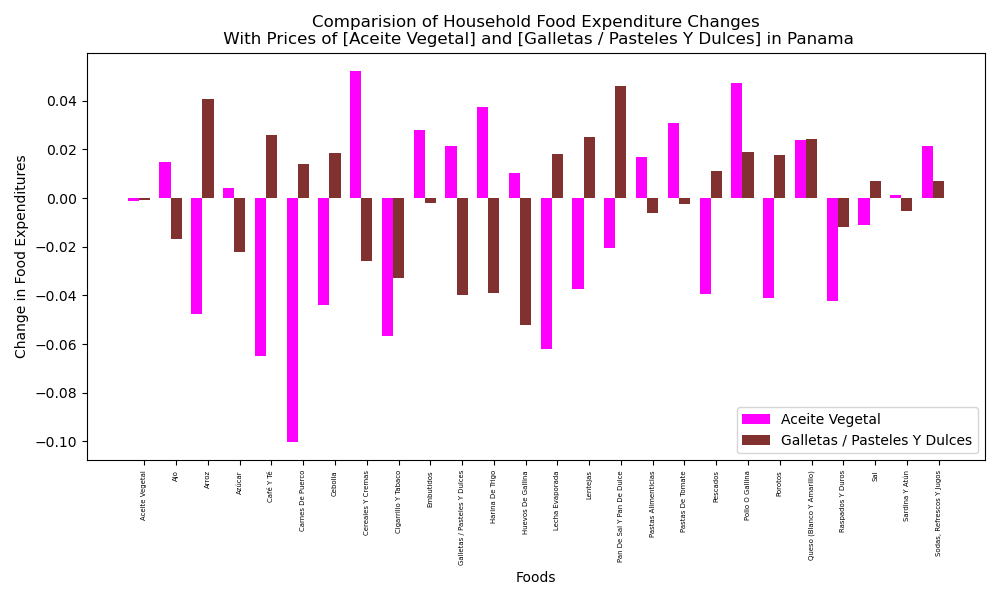

In [22]:
def plot_two_gamma_table(gamma_table, population_groups):
    """
    Ths function is designed to help combine two bar charts displaying food expenditure changes with variations of household composition, and do the comparision.
    
    Parameters:
    - gamma_table (DataFrame): The gamma table above.
    - population_group (list): It should be a list of two population group (string) from the header of gamma table

    Returns:
    - A bar chart described above.
    
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.7 
    num_groups = len(population_groups)
    bar_width = width / num_groups  # Adjusting the bar width for multiple groups
    colors = ['#FF00FF', '#823131']
    for i, population_group in enumerate(population_groups):
        x = range(len(gamma_table.index))
        ax.bar([pos + i * bar_width for pos in x], gamma_table[population_group], bar_width, label=population_group, color=colors[i])

    ax.set_title(f'Comparision of Household Food Expenditure Changes\n With Prices of [{population_groups[0]}] and [{population_groups[1]}] in Panama')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Food Expenditures')
    ax.set_xticks([pos + width / 2 for pos in x])
    ax.set_xticklabels(gamma_table.index, rotation=90, fontsize=5)
    ax.legend()
    plt.tight_layout()
    plt.show()

print("Please choose from the following:\n'Aceite Vegetal', 'Ajo', 'Arroz', 'Azúcar', 'Café Y Té','Carnes De Puerco', 'Cebolla', 'Cereales Y Cremas','Cigarrillo Y Tabaco', 'Embutidos', 'Galletas / Pasteles Y Dulces','Harina De Trigo', 'Huevos De Gallina', 'Lecha Evaporada', 'Lentejas','Pan De Sal Y Pan De Dulce', 'Pastas Alimenticias', 'Pastas De Tomate','Pescados', 'Pollo O Gallina', 'Porotos', 'Queso (Blanco Y Amarillo)','Raspados Y Duros', 'Sal', 'Sardina Y Atún','Sodas, Refrescos Y Jugos'")
print("\n")  
population_input_list_1 = input('Please input the first food you would like to visualize (No quotation mark required): ')
print("\n")  
population_input_list_2 = input('Please input the food you would like to visualize and compare with the first chosen one (No quotation mark required): ')

population_groups = [population_input_list_1, population_input_list_2]  # List of population groups
plot_two_gamma_table(prices_regression_result, population_groups)

### *__<span style = "color:#1FF30E">Interpretation:__*
* <span style = "color:#1FF30E">__*This visualization of the table allows us to compare the price sensitivity of different foods and their related counterparts.*__
* <span style = "color:#1FF30E">__*Taking the longest bar as an example, both <u>"Arroz" (rice) </u> and <u>"Ajo" (garlic) </u> exhibit a decrease in consumption as the price of <u> "Pan De Sal Y Pan De Dulce" (Bread of salt and sweet bread) </u> increases. However, it's evident that <u>"Ajo" </u>is approximately five times more sensitive than <u> "Arroz" </u>, as indicated by the significantly longer bar.*__
* <span style = "color:#1FF30E">__*Zooming out and examining the overall graph, you might notice that for most pairs of bars, <u> "Ajo" </u> consistently exhibits longer bars than <u>"Arroz"</u>. In other words, <u>"Arroz" (rice)</u> is more "inelastic" to price changes compared to foods related to <u>"Ajo" (garlic) </u>. This suggests the potential for tailored policy interventions for these two typical food types.*__

In [23]:
# Avoid Memory Overload
plt.close('all')

<br>


## __[A] Construct Nutrient System__

In [29]:
# The FCT table shows the nutrients of each food item in our dataset. 
fct.head(10)

n,Agua,Energía,Proteina,Grasa Total,Carbo-hidratos,Fibra Diet. total,Ceniza,Calcio,Fosforo,Hierro,...,Colesterol,Potasio,Sodio,Zinc,Magnesio,Vit. B6,Vit. B12,Ac. Fólico,Folato Equiv. FD,Fracción Comestible
j,,,,,,,,,,,,,,,,,,,,,
Aceite Vegetal,0.00,884,0.00,100.00,0.00,0.0,0.00,0,0,0.00,...,0,0,0,0.00,0,0.00,0.0,0,0,1.00
Aguacates,73.23,160,2.00,14.66,8.53,6.7,1.58,12,52,0.55,...,0,485,7,0.64,29,0.26,0.0,0,81,0.74
Ahí Verde,93.89,20,0.86,0.17,3.64,1.7,0.43,10,20,0.34,...,0,175,3,0.13,10,0.22,0.0,0,11,0.82
Ajo,63.80,134,5.30,0.20,29.30,0.0,1.40,38,134,1.40,...,0,529,19,1.00,0,0.00,0.0,3,0,0.94
Alimento Infantil,3.00,510,12.50,27.00,54.30,0.0,3.20,530,420,9.00,...,0,600,180,6.00,55,0.30,1.5,80,136,1.00
Apio,95.43,14,0.69,0.17,2.97,1.6,0.75,40,24,0.20,...,0,260,80,0.13,11,0.07,0.0,0,36,0.89
Arroz,12.37,362,7.50,2.68,76.17,3.4,1.27,33,264,1.80,...,0,268,4,2.02,143,0.51,0.0,0,20,1.00
Arvejas,11.27,341,24.55,1.16,60.37,25.5,2.65,55,366,4.43,...,0,981,15,3.01,115,0.17,0.0,0,274,1.00
Azúcar,0.70,384,0.00,0.00,99.10,0.0,0.20,5,1,0.10,...,0,0,0,0.00,0,0.00,0.0,0,0,1.00


In [30]:
prices_pound.head()

w                    Aceite Vegetal  Aguacates  Ahí Verde   Ajo  \
t    m                                                            
1997 Bocas Del Toro             NaN        NaN       0.50  1.80   
     Chíriqui                   NaN        NaN       0.40  1.45   
     Coclé                      NaN        NaN       0.40  1.00   
     Colón                      NaN        NaN       0.40  1.20   
     Darién                     NaN        NaN       0.35  1.50   

w                    Alimento Infantil      Apio  Arroz  Arvejas  Azúcar  \
t    m                                                                     
1997 Bocas Del Toro                NaN  0.550000   0.35    0.700    0.40   
     Chíriqui                      0.5  0.500000   0.30    0.600    0.30   
     Coclé                         NaN  0.600000   0.30    0.525    0.30   
     Colón                         NaN  0.500000   0.30    0.610    0.31   
     Darién                        NaN  0.833333   0.35    0.800    0.30   

w                    Café Y Té  ...  Segundo otro  Sodas, Refrescos Y Jugos  \
t    m                          ...                                           
1997 Bocas Del Toro      1.770  ...           NaN                       NaN   
     Chíriqui            1.750  ...           NaN                       0.9   
     Coclé               1.600  ...           NaN                       NaN   
     Colón               2.285  ...           NaN                       NaN   
     Darién              1.775  ...           NaN                       0.3   

w                    Tercer otro    Tomate  Viscera De Res  \
t    m                                                       
1997 Bocas Del Toro          NaN  0.700000        1.200000   
     Chíriqui                NaN  0.500000        1.267857   
     Coclé                   NaN  0.500000        1.250000   
     Colón                   NaN  0.525000        1.416667   
     Darién                  NaN  0.283333        1.000000   

w                    Visceras De Pollo O Gallina   Yuca  Zanahoria  \
t    m                                                               
1997 Bocas Del Toro                         0.50  0.200        0.6   
     Chíriqui                               0.60  0.150        0.4   
     Coclé                                  0.75  0.150        0.6   
     Colón                                  0.85  0.250        0.4   
     Darién                                 0.50  0.125        0.5   

w                    Zapallo / Chayote  Ñame  
t    m                                        
1997 Bocas Del Toro               0.30  0.40  
     Chíriqui                     0.25  0.40  
     Coclé                        0.25  0.50  
     Colón                        0.30  0.40  
     Darién                        NaN  0.15  

[5 rows x 76 columns]

In [31]:
# The following table shows the recommended daily intakes for different populations, for males and females of various ages.
rdi.head(10)

k,Females 00-03,Males 00-03,Females 04-08,Males 04-08,Females 09-13,Males 09-13,Females 14-18,Males 14-18,Females 19-30,Males 19-30,Females 31-50,Males 31-50,Females 51-99,Males 51-99
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
Carbohydrate,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
Iron,7.0,7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
Magnesium,80.0,80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
Niacin,6.0,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0


In [32]:
from eep153_tools.sheets import read_sheets

# Get food prices and call it p
url = 'https://docs.google.com/spreadsheets/d/1sfnKHSTXRyLhcDUbVVyVFxyuq6qsp68y9sPkDS-FjgE/edit#gid=2085637103'
p = read_sheets(url,sheet='Food Prices',nheaders=2)

p.columns.names = ['t','m']
p.groupby(level='j').mean()

#use tranpose to switch columns and rows as the original structure of the dataframe was not applicable to use.
p = p.transpose()
if 'm' not in p.columns:
    p['m']=1

p=p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p=p.replace(0,np.nan)

p=p.T
pd.options.display.max_rows=1000

p_per_lb=p.groupby('t',axis=1).median().xs('pound',level='u')

/tmp/ipykernel_274/296694145.py:21: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_per_lb=p.groupby('t',axis=1).median().xs('pound',level='u')


In [33]:
p_per_lb.columns = [1997,2003]

from cfe import regression as rgsn
import numpy as np

# Load a regression model from a pickle file that was named 'estimates.pickle' earlier.
r = rgsn.read_pickle('pj4_estimate_result.pickle')

# Use the loaded model to predict expenditures based on the model's estimates.
xhat = r.predicted_expenditures()

# Implied relative prices
p = np.exp(r.get_Ar())

In [34]:
import matplotlib.pyplot as plt
%matplotlib notebook

use = 'Arroz'  # Put the food item that we want demand curve for here. 
               # 'Arroz' is translated to 'rice' in English. 

# Generates an array of 20 evenly spaced numbers from 0.5 to 2.
scale = np.linspace(.5,2,20)

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

# Reference prices - Calculate the average price for each food item across all observations.
pbar = p.groupby(level='j').mean()

def my_prices(p0,p=pbar,j='Arroz'):
    """
    This changes the food prices of good j while holding other food prices unchanged
    """
    p = p.copy()
    p.loc[j] = p0
    return p

In [35]:
xhat

i         t     m                    j                        
20081     2008  Bocas Del Toro       Aceite Vegetal               5.288339
                                     Ajo                          0.692437
                                     Arroz                        7.311953
                                     Azúcar                       3.079029
                                     Café Y Té                    2.596964
                                                                    ...   
20087040  2008  Comarca Ngobe Bugle  Queso (Blanco Y Amarillo)    1.747443
                                     Raspados Y Duros             1.359181
                                     Sal                          0.618434
                                     Sardina Y Atún               3.677415
                                     Sodas, Refrescos Y Jugos     2.659700
Length: 416806, dtype: float64

In [36]:
qhat = xhat.unstack('j').xs(1997,level='t')/p_per_lb[1997]

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [37]:
use = fct.index.intersection(qhat.columns)

nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

n
Agua                       5999.832021
Energía                   43080.452874
Proteina                   1487.922575
Grasa Total                 815.488224
Carbo-hidratos             7376.747309
Fibra Diet. total           200.574820
Ceniza                      345.527589
Calcio                     5239.057867
Fosforo                   23495.852876
Hierro                      425.553028
Tiamina                      33.976551
Riboﬂavina                   24.243803
Niacina                     420.823591
Vit. C                      146.696909
Vit. A Equiv. Retinol      3213.056676
Ác. grasos mono-insat.      203.208364
Ác. grasos poli-insat.       89.236196
Ác. Grasos saturados        128.407675
Colesterol                 1283.929413
Potasio                   17654.324130
Sodio                     87432.352303
Zinc                         95.201486
Magnesio                   4476.424206
Vit. B6                      29.136304
Vit. B12                     37.846714
Ac. Fólico             

In [38]:
print("Columns in hh_characteristics DataFrame:", HH_characteristics.columns.tolist())
# Define a mapping dictionary to rename columns in hh_characteristics DataFrame
column_mapping = {
    'Males 00-03': 'Males 00-03',
    'Females 00-03': 'Females 00-03',
    'Males 04-08': 'Males 04-08',
    'Females 04-08': 'Females 04-08',
    'Males 09-13': 'Males 09-13',
    'Females 09-13': 'Females 09-13',
    'Males 14-18': 'Males 14-18',
    'Females 14-18': 'Females 14-18',
    'Males 19-30': 'Males 19-30',
    'Females 19-30': 'Females 19-30',
    'Males 31-50': 'Males 31-50',
    'Females 31-50': 'Females 31-50',
    'Males 51-99': 'Males 51-99',
    'Females 51-99': 'Females 51-99',
    'log HSize': 'log HSize'
}

nutrient_translation ={'Energía':'Energy',
                       'Proteina': 'Protein',
                       'Fibra Diet. total' : 'Fiber',
                       'Ac. Folico' : 'Folate',
                       'Calcio' : 'Calcium',
                      'Carbo-hidratos' : 'Carbohydrate',
                      'Hierro': 'Iron',
                       'Fosforo' : 'Phosphorus',
                       'Vit. A Equiv. Retinol' : 'Vitamin A',
                      'Magnesio' : 'Magnesium',
                      'Niacina' : 'Niacin',
                      'Potasio' : 'Potassium',
                      'Vit. B12' : 'Vitamin B-12',
                      'Vit.B6' : 'Vitamin B-6',
                      'Vit. C' : 'Vitamin C',
                      'Zinc' : 'Zinc'}
nutrients_eng=nutrients.rename(columns=nutrient_translation)
nutrients_eng

# Rename columns in hh_characteristics DataFrame using the mapping dictionary
hh_characteristics_eng = HH_characteristics.rename(columns=column_mapping)

hh_characteristics_eng = hh_characteristics_eng[column_mapping.values()]

Columns in hh_characteristics DataFrame: ['women', 'boys', 'men', 'girls', 'Males 00-03', 'Females 00-03', 'Males 04-08', 'Females 04-08', 'Males 09-13', 'Females 09-13', 'Males 14-18', 'Females 14-18', 'Males 19-30', 'Females 19-30', 'Males 31-50', 'Females 31-50', 'Males 51-99', 'Females 51-99', 'log HSize']


In [39]:
print("Columns in rdi DataFrame:", rdi.columns.tolist())
print("Columns in hh_characteristics_eng DataFrame:", hh_characteristics_eng.columns.tolist())


Columns in rdi DataFrame: ['Females 00-03', 'Males 00-03', 'Females 04-08', 'Males 04-08', 'Females 09-13', 'Males 09-13', 'Females 14-18', 'Males 14-18', 'Females 19-30', 'Males 19-30', 'Females 31-50', 'Males 31-50', 'Females 51-99', 'Males 51-99']
Columns in hh_characteristics_eng DataFrame: ['Males 00-03', 'Females 00-03', 'Males 04-08', 'Females 04-08', 'Males 09-13', 'Females 09-13', 'Males 14-18', 'Females 14-18', 'Males 19-30', 'Females 19-30', 'Males 31-50', 'Females 31-50', 'Males 51-99', 'Females 51-99', 'log HSize']


In [40]:
hh_characteristics_eng_select = hh_characteristics_eng[rdi.columns.tolist()]

In [41]:
hh_characteristics_eng_select

,,k,Females 00-03,Males 00-03,Females 04-08,Males 04-08,Females 09-13,Males 09-13,Females 14-18,Males 14-18,Females 19-30,Males 19-30,Females 31-50,Males 31-50,Females 51-99,Males 51-99
i,t,m,,,,,,,,,,,,,,
1997125,1997,Herrera,0,0,0,0,0,1,0,0,0,0,1,0,0,1
1997160,1997,Herrera,0,0,0,0,0,0,0,0,0,0,1,0,1,1
1997170,1997,Bocas Del Toro,2,1,0,1,1,0,1,1,0,0,1,0,0,1
1997177,1997,Bocas Del Toro,1,2,1,4,3,1,0,2,2,0,2,0,0,1
1997178,1997,Bocas Del Toro,0,0,1,0,0,1,1,0,0,2,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20087041,2008,Comarca Ngobe Bugle,1,2,0,1,0,0,0,0,2,1,0,0,1,0
20087042,2008,Comarca Ngobe Bugle,0,2,1,0,1,1,1,0,0,0,1,1,0,0
20087043,2008,Comarca Ngobe Bugle,0,2,1,0,1,1,2,0,0,0,1,1,0,0


In [42]:
hh_rdi = hh_characteristics_eng_select@rdi.T

#check recommended weekly intake?
hh_rwi = hh_rdi*7
use_nutrients = nutrients_eng.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients_eng[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

,,n,Energy,Protein,Carbohydrate,Fiber,Calcium,Phosphorus,Iron,Niacin,Vitamin C,Vitamin A,Potassium,Zinc,Magnesium,Vitamin B-12
i,m,t,,,,,,,,,,,,,,
1997125,Herrera,1997,1.407336,2.055000,3.388466,0.432071,0.307148,1.635653,2.329591,1.845311,0.130320,0.284820,0.224655,0.629154,0.780016,1.106009
1997160,Herrera,1997,1.152101,1.484672,2.673807,0.363704,0.247133,1.634710,1.794877,1.387494,0.086386,0.201601,0.180461,0.514855,0.599808,0.759127
1997170,Bocas Del Toro,1997,0.250491,0.329538,0.564554,0.142296,0.036676,0.258700,0.290445,0.351931,0.025388,0.034134,0.057230,0.186182,0.288190,0.140573
1997180,Bocas Del Toro,1997,0.645718,0.966636,1.524363,0.262077,0.115055,0.675970,0.970746,0.980180,0.089319,0.164557,0.126441,0.365513,0.487477,0.646537
1997269,Chíriqui,1997,1.118048,1.620390,3.028182,0.434935,0.279855,1.831876,1.810262,1.705772,0.131291,0.290482,0.247324,0.617212,0.724387,1.160222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19976665,Panamá,1997,0.951226,1.450974,2.974914,0.453326,0.280346,1.828294,2.849178,1.519604,0.109500,0.213478,0.264696,0.563061,0.690893,0.962953
19976666,Panamá,1997,0.871469,1.149229,2.145383,0.335593,0.204116,1.306788,1.260900,1.141473,0.079777,0.172843,0.166672,0.425992,0.494260,0.689830
19976667,Panamá,1997,0.759146,1.144540,2.179546,0.301208,0.205027,1.317786,1.284822,1.155463,0.081922,0.177767,0.167624,0.434026,0.532061,0.688827


#### Mapping to Nutrients

We need the index of the Food Conversion Table (FCT) to match up with the index of the vector of quantities demanded. 

In [43]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Aceite Vegetal', 'Ajo', 'Arroz', 'Azúcar', 'Café Y Té',
       'Carnes De Puerco', 'Cebolla', 'Cereales Y Cremas', 'Embutidos',
       'Galletas / Pasteles Y Dulces', 'Harina De Trigo', 'Lentejas',
       'Pan De Sal Y Pan De Dulce', 'Pastas Alimenticias', 'Pescados',
       'Pollo O Gallina', 'Porotos', 'Queso (Blanco Y Amarillo)', 'Sal',
       'Sodas, Refrescos Y Jugos'],
      dtype='object', name='j')


In [44]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: Uganda quantities are for previous 7 days

i,1997125,1997160,1997170,1997180,1997269,1997302,1997303,1997304,1997326,1997393,...,19976659,19976660,19976661,19976662,19976664,19976665,19976666,19976667,19976668,19976669
m,Herrera,Herrera,Bocas Del Toro,Bocas Del Toro,Chíriqui,Colón,Colón,Colón,Los Santos,Bocas Del Toro,...,Panamá,Panamá,Panamá,Panamá,Panamá,Panamá,Panamá,Panamá,Panamá,Panamá
n,,,,,,,,,,,,,,,,,,,,,
Agua,8105.733093,6275.325491,2105.920791,6996.624843,4547.802132,2496.622782,3013.435702,2728.170012,4920.662105,6456.847887,...,4260.912198,6063.248472,11228.964970,21139.422468,2982.200143,2164.889048,3244.934512,3207.391815,3109.535319,4462.320025
Energía,55167.586705,43549.427919,24197.465779,55144.358170,32870.617822,22773.763991,27267.149706,22977.410606,37317.535202,50159.990159,...,35265.143456,42117.072061,72975.235750,151586.771594,20716.977385,15980.591679,23181.068928,23381.710543,22798.069793,30703.769945
Proteina,1956.360033,1538.120102,673.575984,1799.876631,1156.958270,699.716449,842.481390,731.836674,1263.234479,1629.300105,...,1145.314152,1465.611131,2627.155808,5307.269916,751.551105,568.781698,820.549210,817.201285,795.341866,1095.037835
Grasa Total,1104.966061,876.670919,331.341700,989.228111,669.257338,372.729601,435.091191,400.301877,667.381304,910.623800,...,600.659616,818.572560,1476.478117,2688.892330,416.143051,309.720930,459.963038,456.002766,443.325413,616.900262
Carbo-hidratos,9250.511949,7299.492077,4623.697282,9710.189652,5511.291318,4131.286003,4960.050526,4086.588341,6501.186098,8821.401996,...,6264.434583,7154.116885,12156.924724,26228.749773,3460.578057,2707.172088,3904.596956,3966.774348,3872.308178,5142.563625
Fibra Diet. total,237.120303,192.471909,192.440436,313.339356,179.019340,140.649609,160.403689,133.350659,189.917404,284.758243,...,194.027507,180.807706,258.461243,635.996210,122.558904,106.622324,124.974924,129.880685,128.090150,145.703867
Ceniza,459.022459,390.968840,289.530706,470.066157,279.227446,229.405412,261.467034,222.838265,330.034596,428.787785,...,318.382229,322.053702,476.823064,1093.015937,220.215555,188.446062,227.674801,223.952096,220.624390,270.354455
Calcio,7095.107699,5535.773374,2310.590977,6120.948322,3917.971237,2444.351069,3004.912288,2553.589642,4542.299132,5627.703631,...,4094.961324,5212.042716,9267.513208,18253.538049,2590.402751,1962.419066,2857.622712,2870.383876,2793.199954,3844.691919


In [45]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

Text(0, 0.5, 'log nutrient')

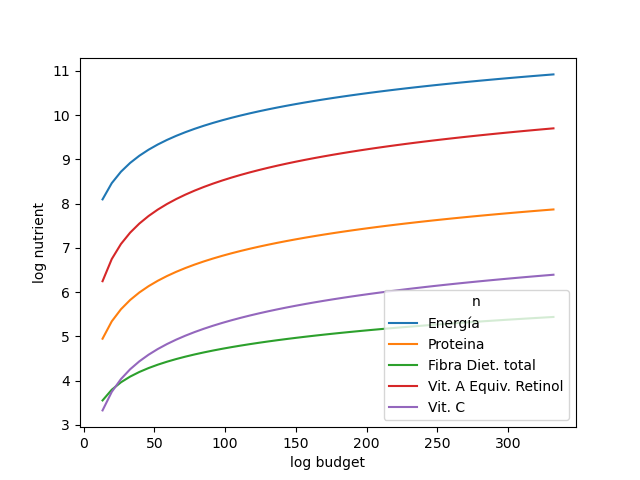

In [46]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Energía','Proteina','Fibra Diet. total','Vit. A Equiv. Retinol','Vit. C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Text(0, 0.5, 'log nutrient')

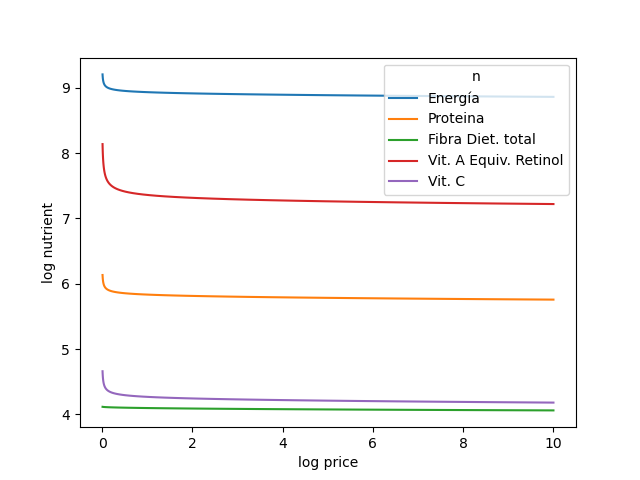

In [47]:
USE_GOOD = 'Lecha Evaporada' # 'Lecha Evaporada' is translated to evaporated milk in English. 

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

For the good evaporated milk, if we changed its price to a very low level, some nutrients of households have an obvious increase. This is possibly because households would purchase more evaporated milk since it is much cheaper, increasing nutrients such as energy, protein and vitamins. As evaporated milk does not contain fiber, we can see there is no changes in log nutrients of fiber.

Text(0, 0.5, 'log nutrient')

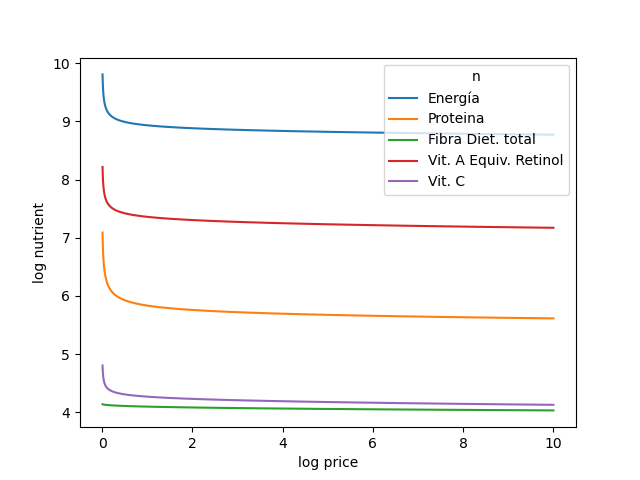

In [48]:
USE_GOOD = 'Pollo O Gallina' # 'Pollo O Gallina' is translated to chicken in English. 

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

In [49]:
fct.index

Index(['Aceite Vegetal', 'Aguacates', 'Ahí Verde', 'Ajo', 'Alimento Infantil',
       'Apio', 'Arroz', 'Arvejas', 'Azúcar', 'Café Y Té', 'Carne De Res',
       'Carnes De Puerco', 'Cebolla', 'Cereales Y Cremas', 'Cervezas',
       'Chocolates', 'Cocos (Pipas)', 'Condimentos',
       'Culanto, Perejil, Cebollina', 'Embutidos', 'Enlatados Y Envasados',
       'Frijoles', 'Galletas / Pasteles Y Dulces', 'Gelatinas',
       'Guineos (Bananos)', 'Harina De Trigo', 'Helados', 'Huevos De Gallina',
       'Lecha Evaporada', 'Leche En Polvo', 'Leche Líquida', 'Lechuga',
       'Lentejas', 'Licores Varios', 'Limones', 'Mangos', 'Manteca',
       'Mantequilla', 'Manzanas', 'Margarina', 'Mariscos', 'Mayonesa',
       'Maíz De Grano', 'Maíz De Mazorca', 'Melones', 'Miel', 'Naranjas',
       'Otoes', 'Pan De Sal Y Pan De Dulce', 'Panela, Raspadura, Etc', 'Papas',
       'Papayas', 'Pastas Alimenticias', 'Pastas De Tomate',
       'Pastillas Y Confites', 'Pepino', 'Pescados', 'Picaritas', 'Piñas',
  

Text(0, 0.5, 'log nutrient')

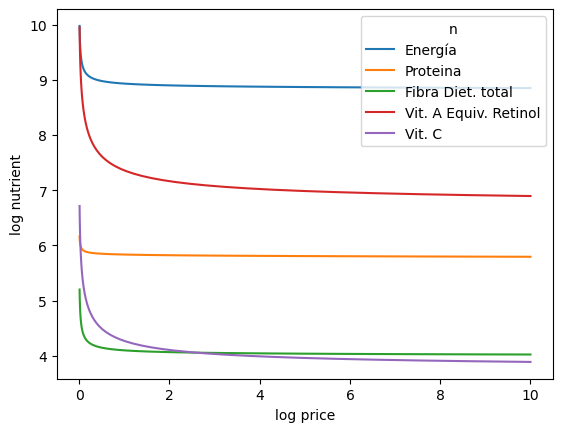

In [61]:
USE_GOOD = 'Cereales Y Cremas' #  'Cereales Y Cremas' is translated to cereal in English. 

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

## Nutritional Needs of Households

In [52]:
# The number of different people can be computed by averaging over households
dbar = r.d[rdi.columns].mean()

In [53]:
# The matrix product gives minimum requirements of nutrients for an average household
hh_rdi = rdi@dbar

hh_rdi

n
Energy           7426.773127
Protein           173.056266
Fiber             103.974824
Folate           1419.721165
Calcium          4327.166116
Carbohydrate      533.542511
Iron               44.439586
Magnesium        1244.135113
Niacin             53.907554
Phosphorus       3174.009731
Potassium       18204.397729
Riboflavin          4.254201
Thiamin             4.112719
Vitamin A        2836.859834
Vitamin B-12        8.518327
Vitamin B-6         4.790094
Vitamin C         266.972117
Vitamin E          53.031190
Vitamin K         349.104859
Zinc               34.189321
dtype: float64

<br>


## __[A] Nutritional Challenges & Policy Goal__

<Axes: >

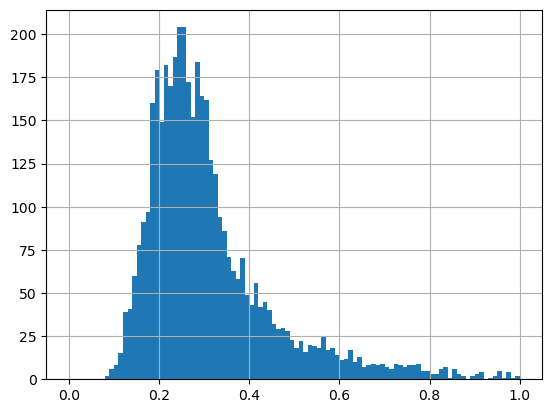

In [58]:
%matplotlib inline
nutrient_ratio['Fiber'].hist(bins=100,range = (0,1))


<Axes: >

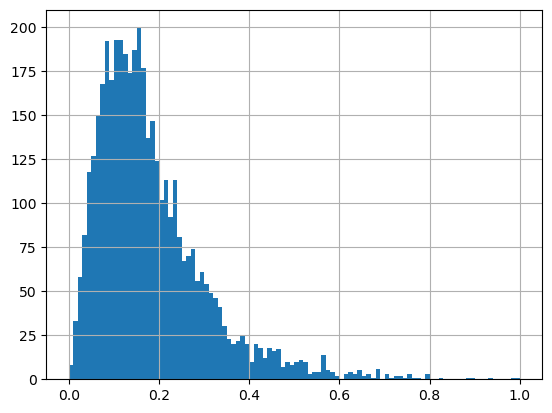

In [59]:
%matplotlib inline
nutrient_ratio['Vitamin A'].hist(bins=100,range = (0,1))

<Axes: >

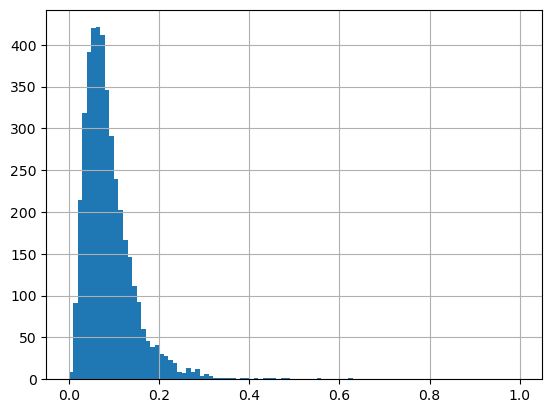

In [60]:
%matplotlib inline
nutrient_ratio['Vitamin C'].hist(bins=100,range = (0,1))

<br>


## __[B] Policy Options__

<br>


## __[C] Policy Cost__

<br>


## __[C] Value of Technical Innovation__